# Setting up the Environment

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dropout, Activation, Dense, BatchNormalization, MaxPooling2D, Flatten, GlobalAveragePooling2D

In [2]:
tf.__version__

'2.0.0'

In [3]:
tf.test.is_gpu_available()

True

# Getting the Data

In [4]:
data = pd.read_csv("sign_mnist_train.csv")
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
data.shape

(27455, 785)

In [6]:
X = data.iloc[:,1:]
y = data[['label']]

# Splitting the Data into Train and Validation

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.4, random_state = 0, shuffle = True)

In [8]:
print("X_train : ", X_train.shape)
print("y_train : ", y_train.shape)
print("X_valid : ", X_valid.shape)
print("y_valid : ", y_valid.shape)

X_train :  (16473, 784)
y_train :  (16473, 1)
X_valid :  (10982, 784)
y_valid :  (10982, 1)


# Reshaping the Train and Validation Data

**The Images have 784 pixels, that is, 28x28 pixels and 1 channel(greyscale).**

In [9]:
X_train = X_train.to_numpy().reshape(-1, 28, 28, 1)  
y_train = y_train.to_numpy()

In [10]:
X_valid = X_valid.to_numpy().reshape(-1, 28, 28, 1)
y_valid = y_valid.to_numpy()

In [11]:
print("X_train : ", X_train.shape)
print("y_train : ", y_train.shape)
print("X_valid : ", X_valid.shape)
print("y_valid : ", y_valid.shape)

X_train :  (16473, 28, 28, 1)
y_train :  (16473, 1)
X_valid :  (10982, 28, 28, 1)
y_valid :  (10982, 1)


In [12]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

In [13]:
np.unique(y_valid)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

# Displaying 10 examples

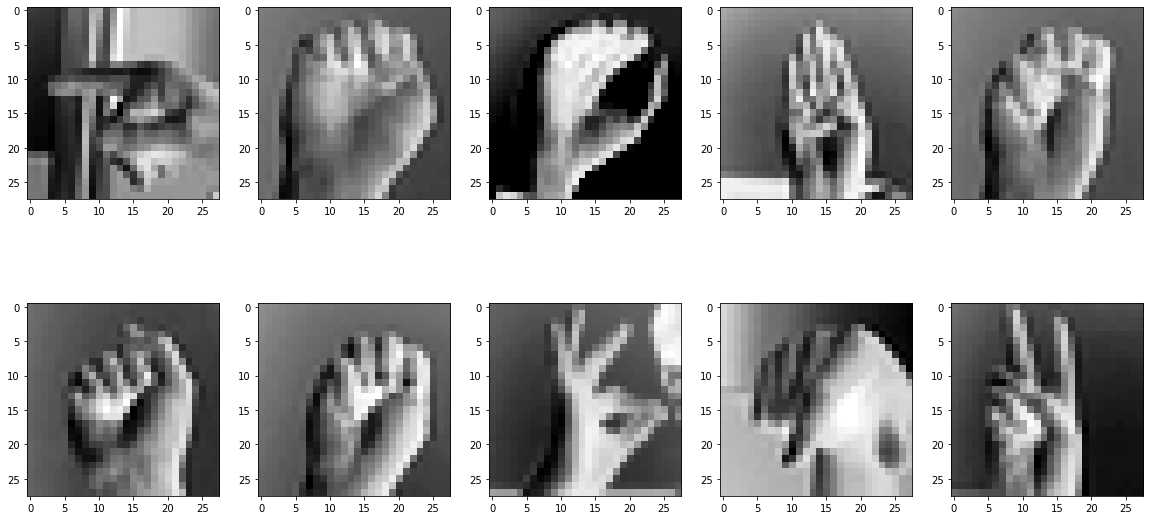

In [14]:
fig = plt.figure(figsize = (20,10))
for j,i in enumerate(range(0,10)):
    plt.subplot(2,5,j+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap = 'Greys')    
plt.show()

# Creating the Convolutional Neural Network

In [15]:
model = Sequential()

model.add(Conv2D(16, kernel_size = 3, padding = 'same', input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
          
model.add(Conv2D(32, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

model.add(Conv2D(32, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

model.add(Conv2D(26, kernel_size = 3, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))

**I have used 26 units in the Output Layer, even though the number of unique classes in the Labels is 24 (from 0-25 excluding 9 and 25). This is because the model will learn to predict 0 for classes 9 and 25, as no such class is present in the training data.**

**I have used Global Average Pooling instead of Fully Connected Layers at the end to tackle overfitting.**

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0

# Creating the Train and Test Image Generators

In [17]:
train_datagen = ImageDataGenerator(rotation_range = 5,
                                   width_shift_range = 0.25,
                                   height_shift_range = 0.25,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rescale = (1./255)) 

valid_datagen = ImageDataGenerator(rescale = 1./255)

In [18]:
train_generator = train_datagen.flow(X_train, y_train, batch_size = 512, shuffle = True)
validation_generator = valid_datagen.flow(X_valid, y_valid, batch_size = 512, shuffle = True)

# Compiling and Fitting the Model

In [19]:
checkpoint = ModelCheckpoint('model.h5', monitor = 'val_accuracy', verbose = 0, save_best_only = True, save_weights_only = False, mode = 'max', period = 1)

W1118 01:25:38.110547 12816 callbacks.py:863] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [20]:
optim = tf.keras.optimizers.Adam(lr = 0.001)
model.compile(optimizer = optim, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [21]:
hist = model.fit_generator(train_generator,
                           steps_per_epoch = len(train_generator),
                           epochs = 50,
                           callbacks = [checkpoint],
                           validation_data = validation_generator,
                           verbose = 2,
                           validation_steps = len(validation_generator),
                           validation_freq = 1)

Epoch 1/50
33/33 - 5s - loss: 2.9234 - accuracy: 0.2469 - val_loss: 3.2621 - val_accuracy: 0.0368
Epoch 2/50
33/33 - 4s - loss: 2.5046 - accuracy: 0.4890 - val_loss: 3.2729 - val_accuracy: 0.0558
Epoch 3/50
33/33 - 4s - loss: 2.1824 - accuracy: 0.6477 - val_loss: 3.2772 - val_accuracy: 0.0477
Epoch 4/50
33/33 - 4s - loss: 1.9327 - accuracy: 0.7367 - val_loss: 3.2478 - val_accuracy: 0.0632
Epoch 5/50
33/33 - 4s - loss: 1.7319 - accuracy: 0.8039 - val_loss: 3.2545 - val_accuracy: 0.0446
Epoch 6/50
33/33 - 4s - loss: 1.5540 - accuracy: 0.8490 - val_loss: 3.2228 - val_accuracy: 0.0537
Epoch 7/50
33/33 - 4s - loss: 1.3989 - accuracy: 0.8751 - val_loss: 3.1674 - val_accuracy: 0.0724
Epoch 8/50
33/33 - 4s - loss: 1.2752 - accuracy: 0.9031 - val_loss: 3.0783 - val_accuracy: 0.0784
Epoch 9/50
33/33 - 4s - loss: 1.1676 - accuracy: 0.9176 - val_loss: 2.8997 - val_accuracy: 0.1383
Epoch 10/50
33/33 - 4s - loss: 1.0687 - accuracy: 0.9368 - val_loss: 2.6998 - val_accuracy: 0.2235
Epoch 11/50
33/33 -

# Plotting the Losses

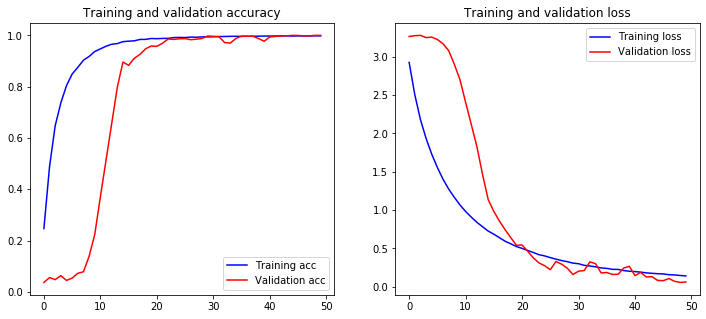

In [22]:
def plot_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


plot_loss(hist)

# Loading the best Model

In [23]:
model = load_model('model.h5')

# Evaluating the Model

In [24]:
train_loss, train_acc = model.evaluate_generator(train_generator, steps = len(train_generator))
print("Train Loss: ", train_loss)
print("Train Acc: ", train_acc)

Train Loss:  0.301929541609504
Train Acc:  0.99022645


In [25]:
validation_loss, validation_acc = model.evaluate_generator(validation_generator, steps = len(validation_generator))
print("Validation Loss: ", validation_loss)
print("Validation Acc: ", validation_acc)

Validation Loss:  0.08301820504394444
Validation Acc:  0.9999089


# Getting the Test Data

In [26]:
test_data = pd.read_csv("sign_mnist_test.csv")
test_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [27]:
test_data.shape

(7172, 785)

In [28]:
X_test = test_data.iloc[:, 1:]
y_test = test_data[['label']]

# Reshaping the Test Data

In [29]:
X_test = X_test.to_numpy().reshape(-1, 28, 28, 1)
y_test = y_test.to_numpy()

In [30]:
print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

X_test :  (7172, 28, 28, 1)
y_test :  (7172, 1)


# Rescaling the Test Input

In [31]:
X_test = X_test / 255

# Predicting the Labels of the Test Data

In [32]:
pred_probs = model.predict(X_test, batch_size = 1024)
print(pred_probs.shape)

(7172, 26)


In [33]:
pred_labels = pred_probs.argmax(axis=1)
print(pred_labels.shape)

(7172,)


# Getting the Test Accuracy

In [34]:
total_correct_labels = np.sum(np.squeeze(y_test) == pred_labels)

In [35]:
test_acc = total_correct_labels / y_test.shape[0]

In [36]:
print("Test Accuracy: {} %".format(test_acc * 100))

Test Accuracy: 99.56776352481874 %


# Creating the Output CSV File

In [37]:
imageid = np.arange(pred_labels.shape[0]) + 1
imageid

array([   1,    2,    3, ..., 7170, 7171, 7172])

In [38]:
df = pd.DataFrame({'ImageId': imageid, 'Label': pred_labels})
df.head()

,ImageId,Label
0,1,6
1,2,5
2,3,10
3,4,0
4,5,3


In [39]:
df.to_csv('test_output.csv', index = False)

**This model gave an accuracy of 99.56% on the Test Dataset.**